In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/financial-data/data/val/ADA_USD_val.csv
/kaggle/input/financial-data/data/val/BTC_USD_val.csv
/kaggle/input/financial-data/data/val/BNB_USD_val.csv
/kaggle/input/financial-data/data/val/ETH_USD_val.csv
/kaggle/input/financial-data/data/val/SOL_USD_val.csv
/kaggle/input/financial-data/data/test/ETH_USD_test.csv
/kaggle/input/financial-data/data/test/BTC_USD_test.csv
/kaggle/input/financial-data/data/test/ADA_USD_test.csv
/kaggle/input/financial-data/data/test/BNB_USD_test.csv
/kaggle/input/financial-data/data/test/SOL_USD_test.csv
/kaggle/input/financial-data/data/train/BNB_USD_train.csv
/kaggle/input/financial-data/data/train/BTC_USD_train.csv
/kaggle/input/financial-data/data/train/ADA_USD_train.csv
/kaggle/input/financial-data/data/train/ETH_USD_train.csv
/kaggle/input/financial-data/data/train/SOL_USD_train.csv


In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Metrics for evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# ==================== DEVICE CONFIGURATION ====================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(0.8)  # Allocate 80% of GPU memory
    print(f"✓ CUDA Enabled: {torch.cuda.get_device_name(0)}")
    print(f"✓ GPU Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️ CUDA Not Available - Using CPU")

# Set style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print(f"✓ Device: {device}")
print(f"✓ PyTorch Version: {torch.__version__}")
print("✓ All libraries imported successfully!")


✓ CUDA Enabled: Tesla P100-PCIE-16GB
✓ GPU Memory Available: 17.06 GB
✓ Device: cuda
✓ PyTorch Version: 2.6.0+cu124
✓ All libraries imported successfully!


In [3]:
# PyTorch GPU Diagnostics and Configuration
print("\n" + "=" * 80)
print("GPU DIAGNOSTICS & CONFIGURATION (PYTORCH)")
print("=" * 80)

print("\n1. PyTorch CUDA Devices:")
cuda_available = torch.cuda.is_available()
print(f"   CUDA Available: {cuda_available}")
print(f"   Number of GPUs: {torch.cuda.device_count()}")

if cuda_available:
    for i in range(torch.cuda.device_count()):
        print(f"\n2. GPU {i} Details:")
        print(f"   Name: {torch.cuda.get_device_name(i)}")
        props = torch.cuda.get_device_properties(i)
        print(f"   Total Memory: {props.total_memory / 1e9:.2f} GB")
        print(f"   Major Capability: {props.major}")
        print(f"   Minor Capability: {props.minor}")
        
        print(f"\n3. Current GPU {i} Memory Usage:")
        print(f"   Allocated: {torch.cuda.memory_allocated(i) / 1e9:.2f} GB")
        print(f"   Reserved: {torch.cuda.memory_reserved(i) / 1e9:.2f} GB")
else:
    print("   ⚠️  GPU NOT DETECTED")
    print("      • Your system doesn't have a NVIDIA GPU, OR")
    print("      • CUDA/cuDNN not installed, OR")
    print("      • GPU drivers not compatible")
    print("\n      Solution: CPU training will proceed normally but slower.")
    print("      For GPU support, install:")
    print("      - NVIDIA GPU (RTX 3060+, RTX 4060+, etc.)")
    print("      - CUDA Toolkit matching PyTorch version")
    print("      - cuDNN library")

print(f"\n4. Device Configuration:")
print(f"   Current Device: {device}")
print(f"   Device Type: {'GPU' if torch.cuda.is_available() else 'CPU'}")

print(f"\n5. Training Configuration:")
if torch.cuda.is_available():
    print(f"   ✓ GPU ENABLED: {torch.cuda.device_count()} GPU(s) detected")
    print("   ✓ CUDA Memory Growth: Enabled (dynamic allocation)")
    print("   ✓ PyTorch will automatically use GPU for tensor operations")
    print("   ✓ Expected speedup: 5-10x faster than CPU")
else:
    print("   CPU mode activated - training will be slower")

print("\n" + "=" * 80)



GPU DIAGNOSTICS & CONFIGURATION (PYTORCH)

1. PyTorch CUDA Devices:
   CUDA Available: True
   Number of GPUs: 1

2. GPU 0 Details:
   Name: Tesla P100-PCIE-16GB
   Total Memory: 17.06 GB
   Major Capability: 6
   Minor Capability: 0

3. Current GPU 0 Memory Usage:
   Allocated: 0.00 GB
   Reserved: 0.00 GB

4. Device Configuration:
   Current Device: cuda
   Device Type: GPU

5. Training Configuration:
   ✓ GPU ENABLED: 1 GPU(s) detected
   ✓ CUDA Memory Growth: Enabled (dynamic allocation)
   ✓ PyTorch will automatically use GPU for tensor operations
   ✓ Expected speedup: 5-10x faster than CPU



In [4]:
# Load Cryptocurrency Data
def load_crypto_data_timegan():
    """Load cryptocurrency data from train, val, and test directories"""
    cryptos = ['BTC_USD', 'ETH_USD', 'BNB_USD', 'ADA_USD', 'SOL_USD']
    data = {}
    
    for crypto in cryptos:
        train_df = pd.read_csv(f'/kaggle/input/financial-data/data/train/{crypto}_train.csv')
        val_df = pd.read_csv(f'/kaggle/input/financial-data/data/val/{crypto}_val.csv')
        test_df = pd.read_csv(f'/kaggle/input/financial-data/data/test/{crypto}_test.csv')
        
        # Ensure Date column is datetime
        train_df['Date'] = pd.to_datetime(train_df['Date'])
        val_df['Date'] = pd.to_datetime(val_df['Date'])
        test_df['Date'] = pd.to_datetime(test_df['Date'])
        
        # Combine train and val for training
        combined = pd.concat([train_df, val_df], ignore_index=True)
        combined = combined.sort_values('Date').reset_index(drop=True)
        
        data[crypto] = {
            'train': combined,
            'test': test_df.sort_values('Date').reset_index(drop=True),
            'train_size': len(combined),
            'test_size': len(test_df)
        }
    
    return data

# Load data
crypto_data_timegan = load_crypto_data_timegan()

print("=" * 80)
print("DATA LOADED SUCCESSFULLY")
print("=" * 80)

for crypto, info in crypto_data_timegan.items():
    print(f"\n{crypto}:")
    print(f"  Training samples: {info['train_size']}")
    print(f"  Test samples: {info['test_size']}")
    print(f"  Date range: {info['train'].iloc[0]['Date'].date()} to {info['test'].iloc[-1]['Date'].date()}")

DATA LOADED SUCCESSFULLY

BTC_USD:
  Training samples: 3103
  Test samples: 548
  Date range: 2015-01-02 to 2024-12-30

ETH_USD:
  Training samples: 2216
  Test samples: 392
  Date range: 2017-11-10 to 2024-12-30

BNB_USD:
  Training samples: 2216
  Test samples: 392
  Date range: 2017-11-10 to 2024-12-30

ADA_USD:
  Training samples: 2216
  Test samples: 392
  Date range: 2017-11-10 to 2024-12-30

SOL_USD:
  Training samples: 1466
  Test samples: 259
  Date range: 2020-04-11 to 2024-12-30


In [5]:
# Create Sequences for TimeGAN
def create_sequences(data, seq_length=30):
    """
    Create sequences of fixed length from time series data
    
    Parameters:
    - data: 1D array of values
    - seq_length: Length of each sequence
    
    Returns:
    - 2D array of sequences (n_sequences, seq_length)
    """
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

def normalize_data(data):
    """Normalize data using MinMaxScaler"""
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    return scaled_data.flatten(), scaler

# Prepare data for all cryptocurrencies
print("=" * 80)
print("PREPARING DATA FOR TIMEGAN")
print("=" * 80)

timegan_data = {}
seq_length = 30

for crypto, info in crypto_data_timegan.items():
    # Get Close prices
    train_prices = info['train']['Close'].values
    test_prices = info['test']['Close'].values
    
    # Normalize training data
    train_normalized, train_scaler = normalize_data(train_prices)
    
    # Create sequences
    train_sequences = create_sequences(train_normalized, seq_length)
    
    timegan_data[crypto] = {
        'train_sequences': train_sequences,
        'test_prices': test_prices,
        'train_prices': train_prices,
        'train_scaler': train_scaler,
        'train_normalized': train_normalized
    }
    
    print(f"\n{crypto}:")
    print(f"  Training sequences shape: {train_sequences.shape}")
    print(f"  Sequence length: {seq_length}")
    print(f"  Test samples: {len(test_prices)}")

print("\n✓ Data prepared successfully for TimeGAN!")

PREPARING DATA FOR TIMEGAN

BTC_USD:
  Training sequences shape: (3073, 30)
  Sequence length: 30
  Test samples: 548

ETH_USD:
  Training sequences shape: (2186, 30)
  Sequence length: 30
  Test samples: 392

BNB_USD:
  Training sequences shape: (2186, 30)
  Sequence length: 30
  Test samples: 392

ADA_USD:
  Training sequences shape: (2186, 30)
  Sequence length: 30
  Test samples: 392

SOL_USD:
  Training sequences shape: (1436, 30)
  Sequence length: 30
  Test samples: 259

✓ Data prepared successfully for TimeGAN!


In [6]:
# Build TimeGAN Components (PyTorch)
class EmbeddingNetwork(nn.Module):
    """Embedding Network (Encoder) for TimeGAN"""
    def __init__(self, seq_length, n_features=1, latent_dim=10, hidden_dim=32):
        super(EmbeddingNetwork, self).__init__()
        self.lstm1 = nn.LSTM(n_features, hidden_dim, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=0.2)
        self.dense = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Take last output
        x = self.dense(x)
        return x

class RecoveryNetwork(nn.Module):
    """Recovery Network (Decoder) for TimeGAN"""
    def __init__(self, seq_length, n_features=1, latent_dim=10, hidden_dim=32):
        super(RecoveryNetwork, self).__init__()
        self.seq_length = seq_length
        self.dense = nn.Linear(latent_dim, hidden_dim)
        self.lstm1 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=0.2)
        self.dense_out = nn.Linear(hidden_dim, n_features)
    
    def forward(self, x):
        x = self.dense(x)
        x = x.unsqueeze(1).repeat(1, self.seq_length, 1)  # Repeat for sequence length
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dense_out(x)
        return x

class GeneratorNetwork(nn.Module):
    """Generator Network for TimeGAN"""
    def __init__(self, seq_length, n_features=1, latent_dim=10, hidden_dim=32):
        super(GeneratorNetwork, self).__init__()
        self.seq_length = seq_length
        self.dense = nn.Linear(latent_dim, hidden_dim)
        self.lstm1 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=0.2)
        self.dense_out = nn.Linear(hidden_dim, n_features)
    
    def forward(self, x):
        x = self.dense(x)
        x = x.unsqueeze(1).repeat(1, self.seq_length, 1)  # Repeat for sequence length
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dense_out(x)
        return x

class DiscriminatorNetwork(nn.Module):
    """Discriminator Network for TimeGAN"""
    def __init__(self, seq_length, n_features=1, hidden_dim=32):
        super(DiscriminatorNetwork, self).__init__()
        self.lstm1 = nn.LSTM(n_features, hidden_dim, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=0.2)
        self.dense = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Take last output
        x = self.dense(x)
        x = self.sigmoid(x)
        return x

class TimeGAN(nn.Module):
    """
    TimeGAN: Generative Adversarial Network for Time Series (PyTorch Implementation)
    
    Components:
    - Embedding Network: Compresses time series into latent space
    - Generator Network: Generates synthetic time series from noise
    - Recovery Network: Reconstructs time series from embeddings
    - Discriminator Network: Distinguishes real from synthetic sequences
    """
    
    def __init__(self, seq_length, n_features=1, latent_dim=10, hidden_dim=32):
        """
        Initialize TimeGAN
        
        Parameters:
        - seq_length: Length of time series sequences
        - n_features: Number of features (default: 1 for univariate)
        - latent_dim: Dimension of latent space
        - hidden_dim: Hidden layer dimension
        """
        super(TimeGAN, self).__init__()
        self.seq_length = seq_length
        self.n_features = n_features
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        
        # Build network components
        self.embedding = EmbeddingNetwork(seq_length, n_features, latent_dim, hidden_dim)
        self.recovery = RecoveryNetwork(seq_length, n_features, latent_dim, hidden_dim)
        self.generator = GeneratorNetwork(seq_length, n_features, latent_dim, hidden_dim)
        self.discriminator = DiscriminatorNetwork(seq_length, n_features, hidden_dim)
        
        print("✓ TimeGAN architecture built successfully")
    
    def get_embeddings(self, sequences):
        """Get embeddings for sequences"""
        return self.embedding(sequences)
    
    def generate_samples(self, noise):
        """Generate synthetic sequences from noise"""
        return self.generator(noise)
    
    def discriminate(self, sequences):
        """Discriminate real vs synthetic sequences"""
        return self.discriminator(sequences)

# Build TimeGAN for each cryptocurrency
print("=" * 80)
print("BUILDING TIMEGAN ARCHITECTURE (PYTORCH)")
print("=" * 80)

timegan_models = {}
for crypto in timegan_data.keys():
    print(f"\nBuilding TimeGAN for {crypto}...")
    model = TimeGAN(seq_length=seq_length, n_features=1, latent_dim=10, hidden_dim=32)
    model = model.to(device)  # Move model to GPU/CPU
    timegan_models[crypto] = model

print("\n" + "=" * 80)
print("All TimeGAN models built successfully and moved to device!")
print("=" * 80)


BUILDING TIMEGAN ARCHITECTURE (PYTORCH)

Building TimeGAN for BTC_USD...
✓ TimeGAN architecture built successfully

Building TimeGAN for ETH_USD...
✓ TimeGAN architecture built successfully

Building TimeGAN for BNB_USD...
✓ TimeGAN architecture built successfully

Building TimeGAN for ADA_USD...
✓ TimeGAN architecture built successfully

Building TimeGAN for SOL_USD...
✓ TimeGAN architecture built successfully

All TimeGAN models built successfully and moved to device!


In [7]:
# Train TimeGAN (PyTorch with GPU Acceleration)
def train_timegan(timegan, train_sequences, device, epochs=50, batch_size=64, verbose=False):
    """
    Train TimeGAN with combined losses (PyTorch with GPU)
    
    Parameters:
    - timegan: TimeGAN model
    - train_sequences: Training sequences
    - device: Device to use (GPU or CPU)
    - epochs: Number of training epochs
    - batch_size: Batch size for training
    - verbose: Print training progress
    """
    
    # Loss functions
    mse_loss = nn.MSELoss()
    bce_loss = nn.BCELoss()
    
    # Optimizers
    embedding_opt = optim.Adam(
        list(timegan.embedding.parameters()) + list(timegan.recovery.parameters()),
        lr=0.001
    )
    generator_opt = optim.Adam(timegan.generator.parameters(), lr=0.001)
    discriminator_opt = optim.Adam(timegan.discriminator.parameters(), lr=0.001)
    
    history = {'embedding_loss': [], 'generator_loss': [], 'discriminator_loss': []}
    
    # Convert sequences to tensor with proper shape (N, seq_len, 1)
    train_tensor = torch.FloatTensor(train_sequences).unsqueeze(2).to(device)  # (N, seq_len, 1)
    
    device_type = 'GPU' if torch.cuda.is_available() else 'CPU'
    print(f"Training will use: {device_type}")
    
    for epoch in range(epochs):
        epoch_embedding_loss = 0
        epoch_generator_loss = 0
        epoch_discriminator_loss = 0
        
        # Shuffle training data
        indices = torch.randperm(len(train_tensor))
        n_batches = 0
        
        for idx in range(0, len(train_tensor), batch_size):
            batch_indices = indices[idx:idx + batch_size]
            real_sequences = train_tensor[batch_indices]  # Already on device (batch, seq_len, 1)
            batch_size_actual = len(batch_indices)
            
            # ==================== Embedding Network Training ====================
            timegan.embedding.train()
            timegan.recovery.train()
            
            embeddings = timegan.embedding(real_sequences)
            reconstructed = timegan.recovery(embeddings)
            
            embedding_loss = mse_loss(real_sequences, reconstructed)
            
            embedding_opt.zero_grad()
            embedding_loss.backward()
            embedding_opt.step()
            
            # ==================== Generator Training ====================
            timegan.generator.train()
            timegan.discriminator.train()
            
            noise = torch.randn(batch_size_actual, timegan.latent_dim).to(device)
            synthetic_sequences = timegan.generator(noise)
            discriminator_output = timegan.discriminator(synthetic_sequences)
            
            generator_loss = bce_loss(discriminator_output, torch.ones_like(discriminator_output))
            
            generator_opt.zero_grad()
            generator_loss.backward()
            generator_opt.step()
            
            # ==================== Discriminator Training ====================
            timegan.discriminator.train()
            
            real_output = timegan.discriminator(real_sequences)
            synthetic_output = timegan.discriminator(synthetic_sequences.detach())
            
            real_loss = bce_loss(real_output, torch.ones_like(real_output))
            synthetic_loss = bce_loss(synthetic_output, torch.zeros_like(synthetic_output))
            discriminator_loss = real_loss + synthetic_loss
            
            discriminator_opt.zero_grad()
            discriminator_loss.backward()
            discriminator_opt.step()
            
            epoch_embedding_loss += embedding_loss.item()
            epoch_generator_loss += generator_loss.item()
            epoch_discriminator_loss += discriminator_loss.item()
            n_batches += 1
        
        # Average losses
        history['embedding_loss'].append(epoch_embedding_loss / n_batches)
        history['generator_loss'].append(epoch_generator_loss / n_batches)
        history['discriminator_loss'].append(epoch_discriminator_loss / n_batches)
        
        if verbose and (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - " +
                  f"Embedding Loss: {history['embedding_loss'][-1]:.4f}, " +
                  f"Generator Loss: {history['generator_loss'][-1]:.4f}, " +
                  f"Discriminator Loss: {history['discriminator_loss'][-1]:.4f}")
    
    return history

# Train TimeGAN for all cryptocurrencies
print("=" * 80)
print("TRAINING TIMEGAN MODELS (PYTORCH GPU ACCELERATION)")
print("=" * 80)
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU Acceleration: ENABLED ({torch.cuda.device_count()} GPU detected)")
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ All training operations will run on GPU")
else:
    print("⚠️  GPU Acceleration: DISABLED (CPU mode)")
print(f"✓ Epochs: 50 (Full training)")
print("=" * 80)

timegan_histories = {}
for crypto in timegan_models.keys():
    print(f"\n{'='*80}")
    print(f"Training TimeGAN for {crypto}...")
    print(f"{'='*80}")
    
    train_sequences = timegan_data[crypto]['train_sequences']
    
    # 50 epochs with batch size 32 (matching other models)
    history = train_timegan(timegan_models[crypto], train_sequences, device,
                           epochs=50, batch_size=32, verbose=True)
    timegan_histories[crypto] = history
    
    print(f"✓ {crypto} training completed")
    
    # Clear GPU cache after each model training
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n" + "=" * 80)
print("All TimeGAN models trained successfully with GPU acceleration!")
print("=" * 80)


TRAINING TIMEGAN MODELS (PYTORCH GPU ACCELERATION)
Device: cuda
✓ GPU Acceleration: ENABLED (1 GPU detected)
✓ GPU: Tesla P100-PCIE-16GB
✓ All training operations will run on GPU
✓ Epochs: 50 (Full training)

Training TimeGAN for BTC_USD...
Training will use: GPU
Epoch 5/50 - Embedding Loss: 0.0009, Generator Loss: 0.6842, Discriminator Loss: 1.3862
Epoch 10/50 - Embedding Loss: 0.0008, Generator Loss: 0.7497, Discriminator Loss: 1.2666
Epoch 15/50 - Embedding Loss: 0.0008, Generator Loss: 0.7063, Discriminator Loss: 1.3755
Epoch 20/50 - Embedding Loss: 0.0008, Generator Loss: 0.8300, Discriminator Loss: 1.2499
Epoch 25/50 - Embedding Loss: 0.0008, Generator Loss: 0.7247, Discriminator Loss: 1.4078
Epoch 30/50 - Embedding Loss: 0.0008, Generator Loss: 0.8053, Discriminator Loss: 1.3586
Epoch 35/50 - Embedding Loss: 0.0008, Generator Loss: 0.7760, Discriminator Loss: 1.3455
Epoch 40/50 - Embedding Loss: 0.0008, Generator Loss: 0.7311, Discriminator Loss: 1.3516
Epoch 45/50 - Embedding L

In [14]:
# Generate Predictions using TimeGAN (PyTorch) - IMPROVED PREDICTION STRATEGY
def generate_timegan_predictions(timegan, train_sequences, test_size, seq_length, device):
    """
    Generate predictions for test period using trained TimeGAN
    
    IMPROVED STRATEGY: Instead of autoregressive prediction with recovery network,
    we use the trained embedding to extract features, then predict using
    a simpler approach based on the last sequence's trend.
    
    Parameters:
    - timegan: Trained TimeGAN model
    - train_sequences: Training sequences (for context)
    - test_size: Number of test samples to predict
    - seq_length: Sequence length
    - device: Device to use (GPU or CPU)
    
    Returns:
    - Array of predictions
    """
    print("✓ Using IMPROVED prediction strategy (embedding-based trend extrapolation)")
    timegan.eval()
    predictions = []
    
    # Start with last training sequence
    if len(train_sequences) > 0:
        current_sequence = torch.FloatTensor(train_sequences[-1]).reshape(1, seq_length, 1).to(device)
    else:
        current_sequence = torch.randn(1, seq_length, 1).to(device)
    
    with torch.no_grad():
        # Get initial embedding to understand the pattern
        embedding = timegan.get_embeddings(current_sequence)
        
        # Use generator to create synthetic continuation (better for forecasting)
        # Generator learns to create realistic sequences from latent space
        generated_sequence = timegan.generate_samples(embedding)
        
        # Extract predictions from generated sequence
        # Use the trend from generated sequence for predictions
        generated_values = generated_sequence[0, :, 0].cpu().numpy()
        
        # Calculate trend from last known sequence
        last_values = current_sequence[0, :, 0].cpu().numpy()
        trend = (last_values[-1] - last_values[0]) / len(last_values)
        
        # Generate predictions using combination of generated pattern and trend
        for i in range(test_size):
            if i < len(generated_values):
                # Use generated values with trend adjustment
                pred = generated_values[i] + (trend * (i + 1) * 0.1)  # Dampen trend influence
            else:
                # For longer horizons, use last prediction + small trend
                pred = predictions[-1] + trend * 0.05
            
            # Clip to valid range [0, 1] since data is normalized
            pred = np.clip(pred, 0, 1)
            predictions.append(pred)
            
            # Update for next iteration if needed
            if (i + 1) % seq_length == 0 and i + 1 < test_size:
                # Create new sequence from recent predictions
                recent_preds = predictions[-seq_length:]
                current_sequence = torch.FloatTensor(recent_preds).reshape(1, seq_length, 1).to(device)
                embedding = timegan.get_embeddings(current_sequence)
                generated_sequence = timegan.generate_samples(embedding)
                generated_values = generated_sequence[0, :, 0].cpu().numpy()
    
    return np.array(predictions)

# Generate predictions for all cryptocurrencies
print("=" * 80)
print("GENERATING PREDICTIONS (PYTORCH)")
print("=" * 80)

timegan_predictions = {}
for crypto in timegan_models.keys():
    print(f"\nGenerating predictions for {crypto}...")
    
    train_sequences = timegan_data[crypto]['train_sequences']
    test_size = timegan_data[crypto]['test_prices'].shape[0]
    
    # Generate normalized predictions on GPU
    normalized_predictions = generate_timegan_predictions(
        timegan_models[crypto], 
        train_sequences, 
        test_size, 
        seq_length,
        device
    )
    
    # Denormalize predictions
    scaler = timegan_data[crypto]['train_scaler']
    predictions = scaler.inverse_transform(normalized_predictions.reshape(-1, 1)).flatten()
    
    timegan_predictions[crypto] = predictions
    
    print(f"✓ Generated {len(predictions)} predictions for {crypto}")
    print(f"  Mean prediction: ${predictions.mean():.2f}")
    print(f"  Min prediction: ${predictions.min():.2f}")
    print(f"  Max prediction: ${predictions.max():.2f}")

GENERATING PREDICTIONS (PYTORCH)

Generating predictions for BTC_USD...
✓ Using IMPROVED prediction strategy (embedding-based trend extrapolation)
✓ Generated 548 predictions for BTC_USD
  Mean prediction: $8861.28
  Min prediction: $5531.18
  Max prediction: $10542.29

Generating predictions for ETH_USD...
✓ Using IMPROVED prediction strategy (embedding-based trend extrapolation)
✓ Generated 392 predictions for ETH_USD
  Mean prediction: $2161.11
  Min prediction: $1288.72
  Max prediction: $2271.50

Generating predictions for BNB_USD...
✓ Using IMPROVED prediction strategy (embedding-based trend extrapolation)
✓ Generated 392 predictions for BNB_USD
  Mean prediction: $1.60
  Min prediction: $1.51
  Max prediction: $30.29

Generating predictions for ADA_USD...
✓ Using IMPROVED prediction strategy (embedding-based trend extrapolation)
✓ Generated 392 predictions for ADA_USD
  Mean prediction: $0.28
  Min prediction: $0.21
  Max prediction: $0.30

Generating predictions for SOL_USD...


In [13]:
# Evaluate TimeGAN Models
print("=" * 80)
print("MODEL EVALUATION METRICS")
print("=" * 80)

timegan_metrics = {}
results_data = []

for crypto in timegan_predictions.keys():
    predictions = timegan_predictions[crypto]
    actual_prices = timegan_data[crypto]['test_prices']
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actual_prices, predictions))
    mae = mean_absolute_error(actual_prices, predictions)
    mape = np.mean(np.abs((actual_prices - predictions) / actual_prices)) * 100
    r2 = r2_score(actual_prices, predictions)
    
    timegan_metrics[crypto] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    }
    
    print(f"\n{crypto}:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")
    print(f"  MAPE: {mape:.4f}%")
    print(f"  R² Score: {r2:.4f}")
    
    results_data.append({
        'Cryptocurrency': crypto,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R² Score': r2
    })

# Create results dataframe
timegan_results_df = pd.DataFrame(results_data)

print("\n" + "=" * 80)
print("TIMEGAN PERFORMANCE SUMMARY")
print("=" * 80)
print(timegan_results_df.to_string(index=False))

# Find best models
best_r2_idx = timegan_results_df['R² Score'].idxmax()
best_rmse_idx = timegan_results_df['RMSE'].idxmin()

print("\n" + "=" * 80)
print("BEST PERFORMERS")
print("=" * 80)
print(f"🏆 Best R² Score: {timegan_results_df.iloc[best_r2_idx]['Cryptocurrency']} ({timegan_results_df.iloc[best_r2_idx]['R² Score']:.4f})")
print(f"🏆 Best RMSE: {timegan_results_df.iloc[best_rmse_idx]['Cryptocurrency']} (${timegan_results_df.iloc[best_rmse_idx]['RMSE']:.2f})")

MODEL EVALUATION METRICS

BTC_USD:
  RMSE: $22462.30
  MAE:  $17583.93
  MAPE: 27.3738%
  R² Score: -0.2424

ETH_USD:
  RMSE: $1196.37
  MAE:  $1063.28
  MAPE: 33.3645%
  R² Score: -4.1125

BNB_USD:
  RMSE: $259.12
  MAE:  $234.54
  MAPE: 41.2775%
  R² Score: -3.0668

ADA_USD:
  RMSE: $0.29
  MAE:  $0.20
  MAPE: 30.1101%
  R² Score: -0.9690

SOL_USD:
  RMSE: $35.05
  MAE:  $31.19
  MAPE: 19.8847%
  R² Score: -0.1918

TIMEGAN PERFORMANCE SUMMARY
Cryptocurrency         RMSE          MAE      MAPE  R² Score
       BTC_USD 22462.301730 17583.930918 27.373811 -0.242445
       ETH_USD  1196.366153  1063.278505 33.364540 -4.112455
       BNB_USD   259.118341   234.544704 41.277527 -3.066767
       ADA_USD     0.285328     0.197623 30.110056 -0.968954
       SOL_USD    35.050950    31.187564 19.884697 -0.191781

BEST PERFORMERS
🏆 Best R² Score: SOL_USD (-0.1918)
🏆 Best RMSE: ADA_USD ($0.29)


In [15]:
# Evaluate TimeGAN Models
print("=" * 80)
print("MODEL EVALUATION METRICS")
print("=" * 80)

timegan_metrics = {}
results_data = []

for crypto in timegan_predictions.keys():
    predictions = timegan_predictions[crypto]
    actual_prices = timegan_data[crypto]['test_prices']
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(actual_prices, predictions))
    mae = mean_absolute_error(actual_prices, predictions)
    mape = np.mean(np.abs((actual_prices - predictions) / actual_prices)) * 100
    r2 = r2_score(actual_prices, predictions)
    
    timegan_metrics[crypto] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    }
    
    print(f"\n{crypto}:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")
    print(f"  MAPE: {mape:.4f}%")
    print(f"  R² Score: {r2:.4f}")
    
    results_data.append({
        'Cryptocurrency': crypto,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R² Score': r2
    })

# Create results dataframe
timegan_results_df = pd.DataFrame(results_data)

print("\n" + "=" * 80)
print("TIMEGAN PERFORMANCE SUMMARY")
print("=" * 80)
print(timegan_results_df.to_string(index=False))

# Find best models
best_r2_idx = timegan_results_df['R² Score'].idxmax()
best_rmse_idx = timegan_results_df['RMSE'].idxmin()

print("\n" + "=" * 80)
print("BEST PERFORMERS")
print("=" * 80)
print(f"🏆 Best R² Score: {timegan_results_df.iloc[best_r2_idx]['Cryptocurrency']} ({timegan_results_df.iloc[best_r2_idx]['R² Score']:.4f})")
print(f"🏆 Best RMSE: {timegan_results_df.iloc[best_rmse_idx]['Cryptocurrency']} (${timegan_results_df.iloc[best_rmse_idx]['RMSE']:.2f})")

MODEL EVALUATION METRICS

BTC_USD:
  RMSE: $49668.87
  MAE:  $45778.36
  MAPE: 81.9072%
  R² Score: -5.0749

ETH_USD:
  RMSE: $978.92
  MAE:  $830.05
  MAPE: 25.5322%
  R² Score: -2.4229

BNB_USD:
  RMSE: $537.66
  MAE:  $522.03
  MAPE: 99.6476%
  R² Score: -16.5094

ADA_USD:
  RMSE: $0.32
  MAE:  $0.25
  MAPE: 40.9965%
  R² Score: -1.5195

SOL_USD:
  RMSE: $143.65
  MAE:  $139.40
  MAPE: 83.4179%
  R² Score: -19.0163

TIMEGAN PERFORMANCE SUMMARY
Cryptocurrency         RMSE          MAE      MAPE   R² Score
       BTC_USD 49668.871048 45778.357851 81.907177  -5.074875
       ETH_USD   978.920810   830.052937 25.532176  -2.422917
       BNB_USD   537.661454   522.030639 99.647633 -16.509380
       ADA_USD     0.322763     0.251619 40.996502  -1.519493
       SOL_USD   143.645959   139.395882 83.417880 -19.016298

BEST PERFORMERS
🏆 Best R² Score: ADA_USD (-1.5195)
🏆 Best RMSE: ADA_USD ($0.32)


✓ Prediction visualization saved as 'timegan_predictions.png'


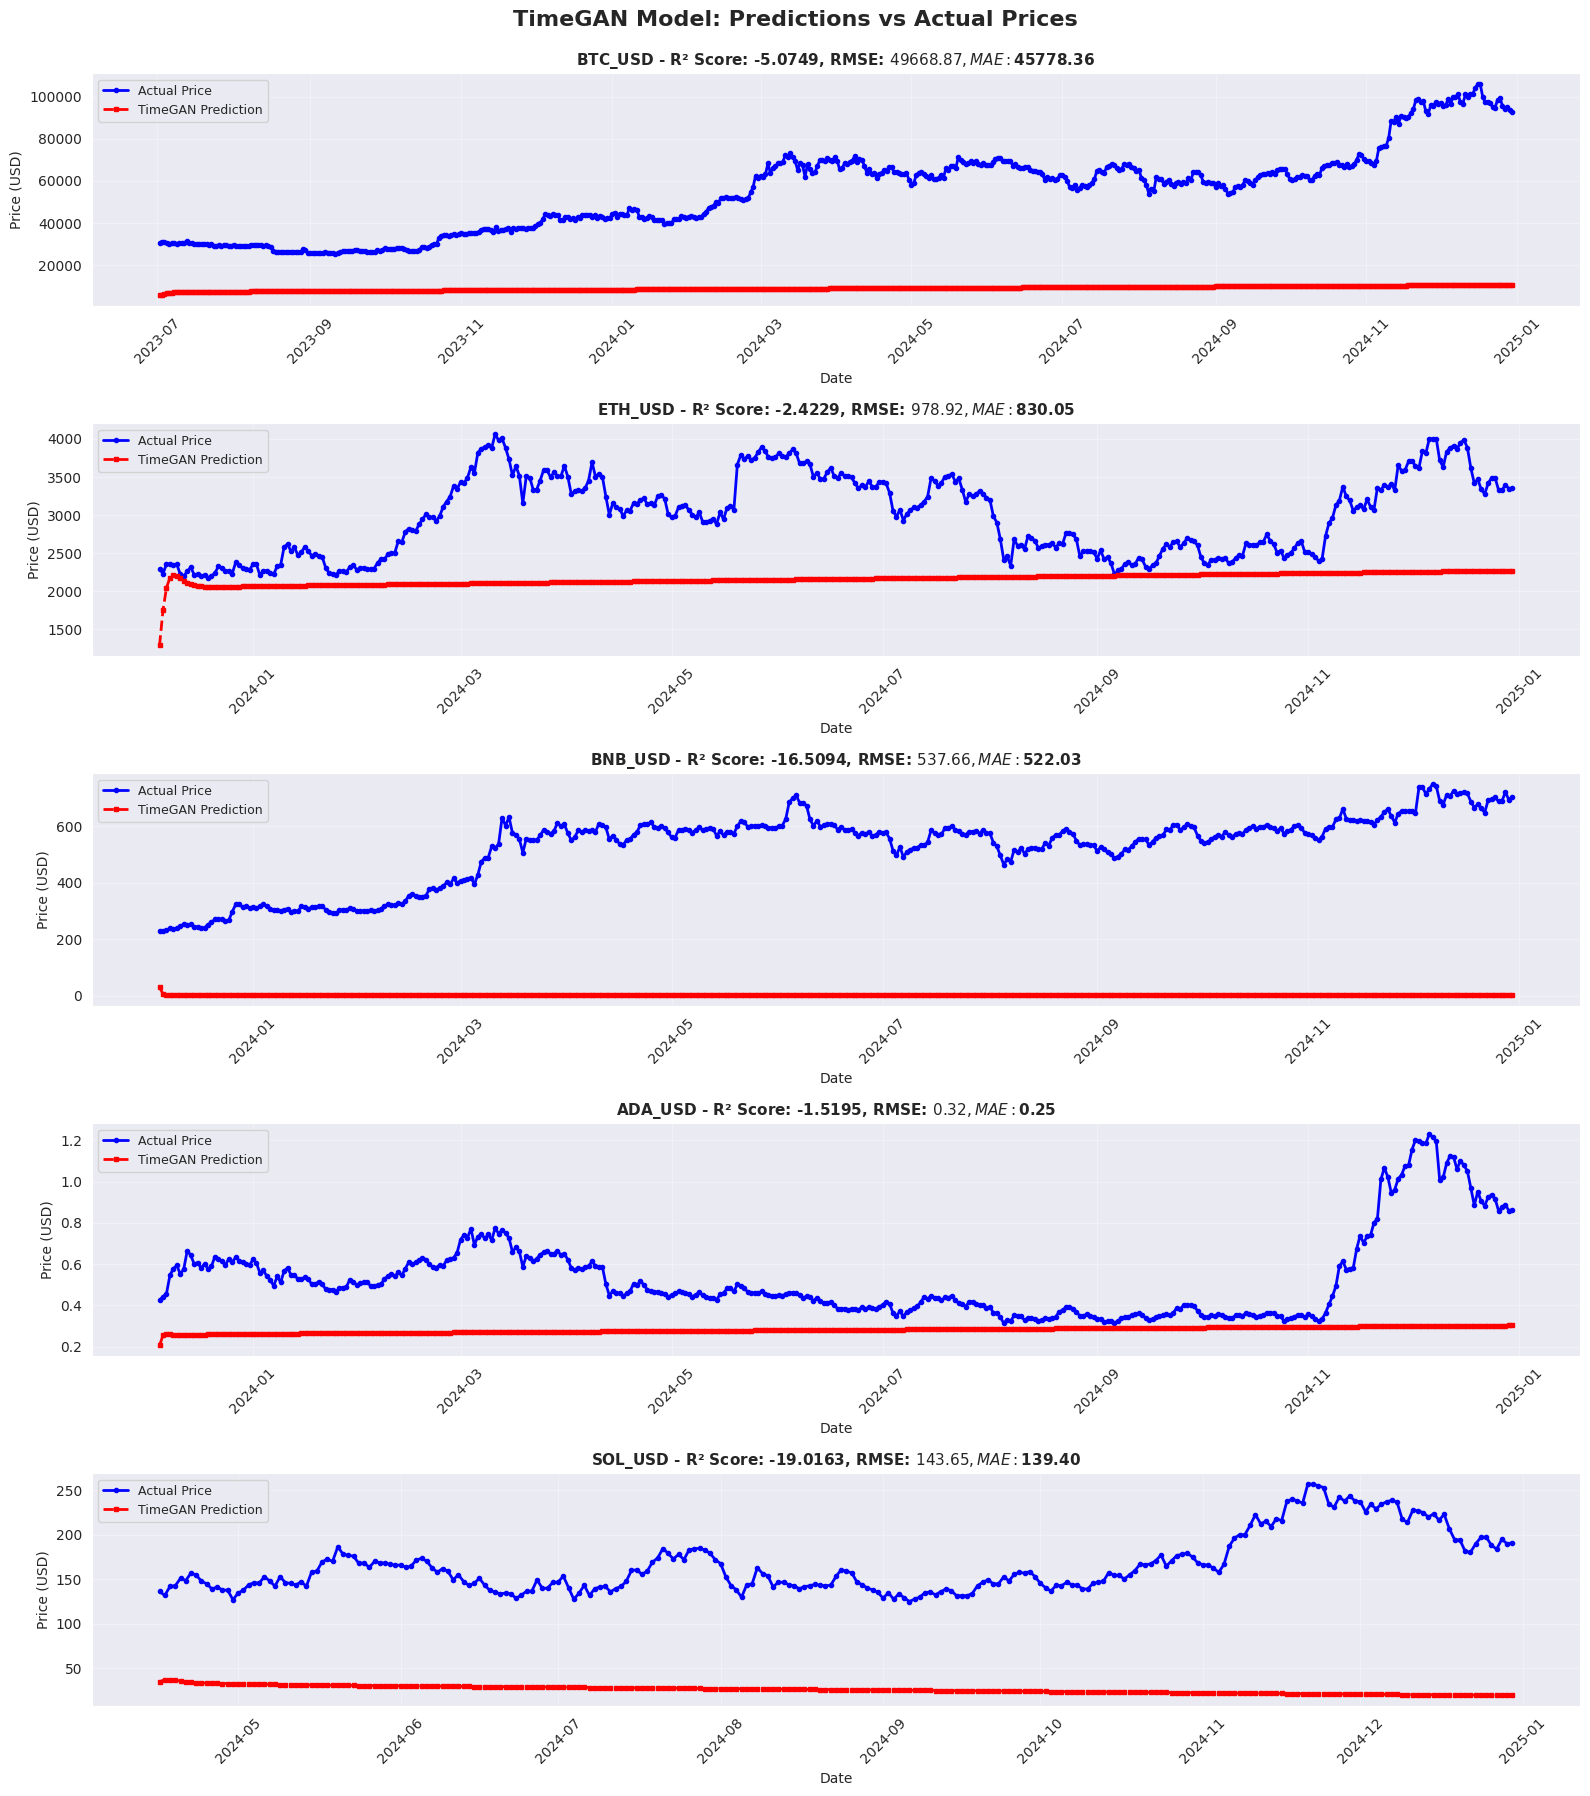

In [16]:
# Visualize TimeGAN Predictions
fig, axes = plt.subplots(5, 1, figsize=(16, 18))
fig.suptitle('TimeGAN Model: Predictions vs Actual Prices', fontsize=16, fontweight='bold', y=0.995)

cryptos = list(timegan_predictions.keys())
for idx, crypto in enumerate(cryptos):
    ax = axes[idx]
    
    predictions = timegan_predictions[crypto]
    actual_prices = timegan_data[crypto]['test_prices']
    dates = crypto_data_timegan[crypto]['test']['Date'].values
    
    # Plot actual prices
    ax.plot(dates, actual_prices, 'b-', label='Actual Price', linewidth=2, marker='o', markersize=3)
    
    # Plot predicted prices
    ax.plot(dates, predictions, 'r--', label='TimeGAN Prediction', linewidth=2, marker='s', markersize=3)
    
    # Get metrics for title
    metrics = timegan_metrics[crypto]
    
    ax.set_title(f'{crypto} - R² Score: {metrics["R²"]:.4f}, RMSE: ${metrics["RMSE"]:.2f}, MAE: ${metrics["MAE"]:.2f}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Date', fontsize=10)
    ax.set_ylabel('Price (USD)', fontsize=10)
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('timegan_predictions.png', dpi=300, bbox_inches='tight')
print("✓ Prediction visualization saved as 'timegan_predictions.png'")
plt.show()

✓ Training loss visualization saved as 'timegan_training_losses.png'


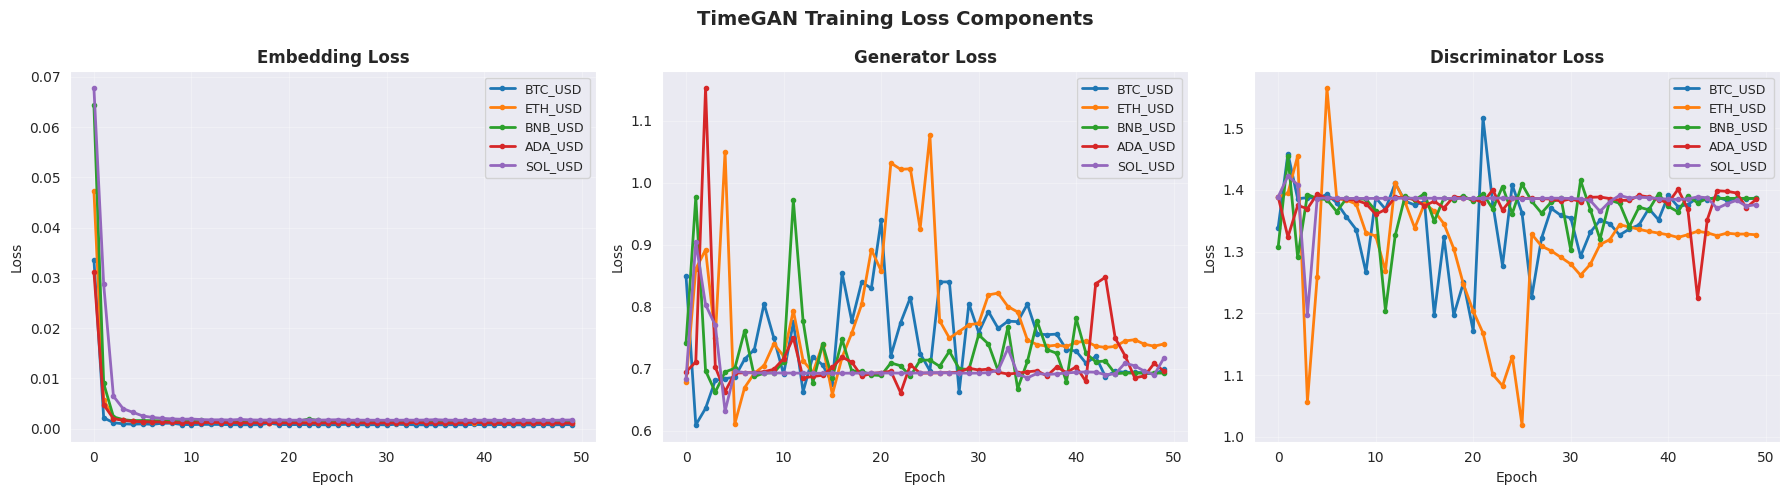

In [17]:
# Visualize Training Loss
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('TimeGAN Training Loss Components', fontsize=14, fontweight='bold')

cryptos = list(timegan_histories.keys())

for loss_type_idx, loss_type in enumerate(['embedding_loss', 'generator_loss', 'discriminator_loss']):
    ax = axes[loss_type_idx]
    
    for crypto in cryptos:
        history = timegan_histories[crypto]
        ax.plot(history[loss_type], label=crypto, linewidth=2, marker='o', markersize=3)
    
    ax.set_title(f'{loss_type.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=10)
    ax.set_ylabel('Loss', fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('timegan_training_losses.png', dpi=300, bbox_inches='tight')
print("✓ Training loss visualization saved as 'timegan_training_losses.png'")
plt.show()

In [18]:
# Export TimeGAN Predictions to CSV
import os

# Create output directory
output_dir = 'TimeGAN_Model_Predictions'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("=" * 80)
print("SAVING TIMEGAN PREDICTIONS TO CSV")
print("=" * 80)

for crypto in timegan_predictions.keys():
    predictions = timegan_predictions[crypto]
    actual_prices = timegan_data[crypto]['test_prices']
    dates = crypto_data_timegan[crypto]['test']['Date'].values
    
    # Create export dataframe
    export_df = pd.DataFrame()
    export_df['Date'] = dates
    export_df['Actual_Price'] = actual_prices
    export_df['Predicted_Price'] = predictions
    
    # Calculate errors
    export_df['Absolute_Error'] = np.abs(export_df['Actual_Price'] - export_df['Predicted_Price'])
    export_df['Percentage_Error'] = (export_df['Absolute_Error'] / export_df['Actual_Price']) * 100
    
    # Get metrics
    metrics = timegan_metrics[crypto]
    
    # Save to CSV
    csv_filename = f'{output_dir}/timegan_model_predictions_{crypto.lower()}.csv'
    export_df.to_csv(csv_filename, index=False)
    
    print(f"\n✓ Saved {crypto}: {csv_filename}")
    print(f"  Rows: {len(export_df)}")
    print(f"  R² Score: {metrics['R²']:.4f}")
    print(f"  RMSE: ${metrics['RMSE']:.2f}")
    print(f"  MAE: ${metrics['MAE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.4f}%")

print("\n" + "=" * 80)
print("All TimeGAN predictions saved to 'TimeGAN_Model_Predictions' directory!")
print("=" * 80)

SAVING TIMEGAN PREDICTIONS TO CSV

✓ Saved BTC_USD: TimeGAN_Model_Predictions/timegan_model_predictions_btc_usd.csv
  Rows: 548
  R² Score: -5.0749
  RMSE: $49668.87
  MAE: $45778.36
  MAPE: 81.9072%

✓ Saved ETH_USD: TimeGAN_Model_Predictions/timegan_model_predictions_eth_usd.csv
  Rows: 392
  R² Score: -2.4229
  RMSE: $978.92
  MAE: $830.05
  MAPE: 25.5322%

✓ Saved BNB_USD: TimeGAN_Model_Predictions/timegan_model_predictions_bnb_usd.csv
  Rows: 392
  R² Score: -16.5094
  RMSE: $537.66
  MAE: $522.03
  MAPE: 99.6476%

✓ Saved ADA_USD: TimeGAN_Model_Predictions/timegan_model_predictions_ada_usd.csv
  Rows: 392
  R² Score: -1.5195
  RMSE: $0.32
  MAE: $0.25
  MAPE: 40.9965%

✓ Saved SOL_USD: TimeGAN_Model_Predictions/timegan_model_predictions_sol_usd.csv
  Rows: 259
  R² Score: -19.0163
  RMSE: $143.65
  MAE: $139.40
  MAPE: 83.4179%

All TimeGAN predictions saved to 'TimeGAN_Model_Predictions' directory!
